<a href="https://colab.research.google.com/github/xseeker0/neural-scratchpad/blob/main/practice_3_1_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

## Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load a dataset from Hugging face
from datasets import load_dataset
ds = load_dataset("microsoft/cats_vs_dogs")

print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})


In [2]:
# Split 80/20
ds = ds["train"].train_test_split(
    test_size=0.2,
    seed=42
)

train_ds = ds["train"]
val_ds   = ds["test"]

class CatsDogsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]   # Raw PIL Image
        label = item["labels"]  # Target labels: 0 = cat, 1 = dog

        if self.transform:
            image = self.transform(image)

        return image, label

def letterbox(
    image: Image.Image,
    size: int = 224,
    fill: int | tuple = 0
):
    """
    image: PIL Image input
    size: Target square output dimension (224x224)
    fill: Padding color (0 for black, or (R, G, B) tuple)
    """
    w, h = image.size

    # Scale based on the longest side to maintain aspect ratio
    scale = size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize while maintaining aspect ratio
    image = F.resize(image, (new_h, new_w))

    # Calculate required padding for each side
    pad_w = size - new_w
    pad_h = size - new_h

    padding = (
        pad_w // 2,               # left
        pad_h // 2,               # top
        pad_w - pad_w // 2,       # right
        pad_h - pad_h // 2        # bottom
    )

    # Apply padding and ensure output is in RGB format
    image = F.pad(image, padding, fill=fill)
    return image.convert("RGB")

# Image transformation pipeline
transform = transforms.Compose([
    # Apply custom letterbox resizing
    transforms.Lambda(lambda img: letterbox(img, size=224, fill=0)),
    transforms.ToTensor(),
    # Normalize using ImageNet statistics for better convergence
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std =[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# Initialize training and validation datasets
train_dataset = CatsDogsDataset(train_ds, transform=transform)
val_dataset   = CatsDogsDataset(val_ds, transform=transform)

batch_size = 32*8
# Create DataLoaders for batch processing
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

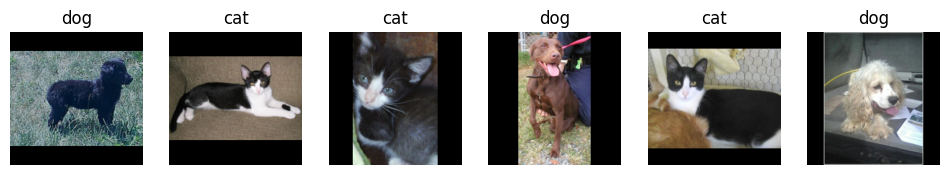

In [3]:
def visualize_ds(images, labels, class_names=None, n=8):
    """
    images: Tensor [B, C, H, W]
    labels: Tensor [B]
    class_names: list[str] or None
    n: number of imgs to plot
    """
    images = images[:n]
    labels = labels[:n]

    # Convert tensor -> numpy (B, H, W, C)
    images = images.permute(0, 2, 3, 1).cpu().numpy()

    # unnormalize
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std  = np.array([0.229, 0.224, 0.225])

    images = (images * imagenet_std) + imagenet_mean
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(n * 2, 3))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

        if class_names:
            plt.title(class_names[labels[i]])
        else:
            plt.title(f"Label: {labels[i].item()}")

    plt.show()

images, labels = next(iter(val_loader))

class_names = ["cat", "dog"]

visualize_ds(images, labels, class_names=class_names, n=6)


## CNN layer

### CNN layer (2D)

In [4]:
class MyConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Weight shape: (out_channels, in_channels, kernel_height, kernel_width)
        # Using a small scale (0.1) for initial weights
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        # 1. Apply Zero Padding to the input boundaries
        if self.padding > 0:
            # Padding format: (left, right, top, bottom)
            x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        batch_size, in_c, h, w = x.shape
        # Calculate output spatial dimensions
        out_h = (h - self.kernel_size) // self.stride + 1
        out_w = (w - self.kernel_size) // self.stride + 1

        # 2. Initialize output tensor with zeros
        output = torch.zeros(batch_size, self.out_channels, out_h, out_w).to(x.device)

        # 3. Perform the Convolution operation (sliding window)
        for b in range(batch_size):
            for oc in range(self.out_channels): # Iterate through each filter
                for i in range(0, out_h):
                    for j in range(0, out_w):
                        # Calculate the window coordinates on the input image
                        h_start = i * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = j * self.stride
                        w_end = w_start + self.kernel_size

                        # Extract the local patch (region of interest)
                        patch = x[b, :, h_start:h_end, w_start:w_end]

                        # Compute convolution: Element-wise multiply then sum across all channels + bias
                        output[b, oc, i, j] = torch.sum(patch * self.weight[oc]) + self.bias[oc]
        return output

### Pooling

In [5]:
class MyMaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None):
        super().__init__()
        self.kernel_size = kernel_size
        # If stride is not provided, it defaults to kernel_size
        self.stride = stride if stride is not None else kernel_size

    def forward(self, x):
        batch, c, h, w = x.shape
        # Calculate output spatial dimensions after downsampling
        out_h = (h - self.kernel_size) // self.stride + 1
        out_w = (w - self.kernel_size) // self.stride + 1

        # Pre-allocate output tensor
        output = torch.zeros(batch, c, out_h, out_w).to(x.device)

        # Perform Max Pooling: Reduces spatial size while retaining the most prominent features
        for b in range(batch):
            for ch in range(c): # Pooling is performed independently for each channel
                for i in range(out_h):
                    for j in range(out_w):
                        # Determine the pooling window start position based on stride
                        h_start = i * self.stride
                        w_start = j * self.stride

                        # Select the local window (patch)
                        patch = x[b, ch, h_start:h_start+self.kernel_size, w_start:w_start+self.kernel_size]

                        # Keep only the maximum value within the window
                        output[b, ch, i, j] = torch.max(patch)
        return output

### Test with an image

In [6]:
# Hyperparams
in_channels = 3
out_channels = 4
kernel_size = 3
stride = 1
padding = 1

# Custom conv
my_conv = MyConv2d(
    in_channels, out_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding
)

# PyTorch conv
torch_conv = nn.Conv2d(
    in_channels, out_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding,
    bias=True
)

# Copy weight & bias
with torch.no_grad():
    torch_conv.weight.copy_(my_conv.weight)
    torch_conv.bias.copy_(my_conv.bias)

x, _ = next(iter(val_loader))
x = x[:1]

# Forward
out_my = my_conv(x)
out_torch = torch_conv(x)

# diff
diff = out_my - out_torch

print("Output shape:", out_my.shape)
print("Max abs error:", diff.abs().max().item())
print("Mean abs error:", diff.abs().mean().item())


Output shape: torch.Size([1, 4, 224, 224])
Max abs error: 7.152557373046875e-07
Mean abs error: 3.143359705859439e-08


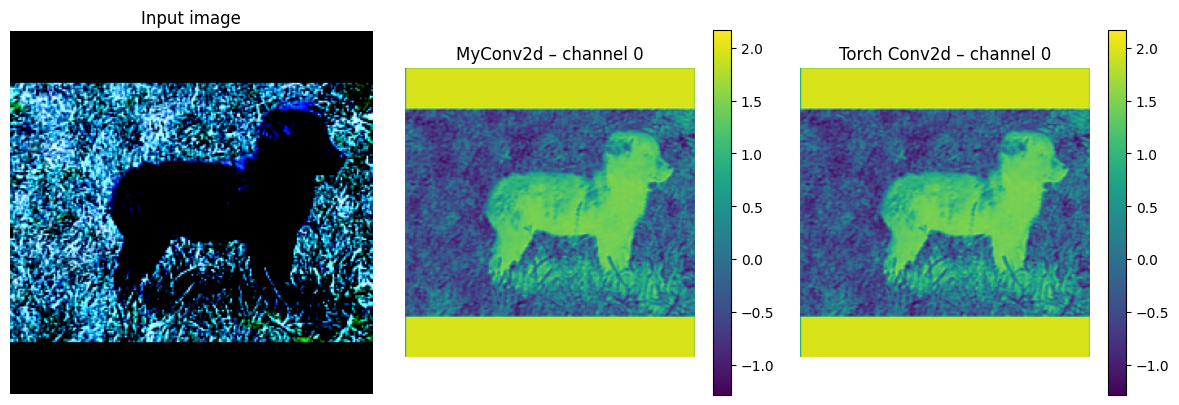

In [7]:
def show_feature_map(fmap, title):
    fmap = fmap.detach().cpu().numpy()
    plt.imshow(fmap, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.axis("off")

img = x[0]

plt.figure(figsize=(12, 4))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0).cpu())
plt.title("Input image")
plt.axis("off")

# MyConv2d output
plt.subplot(1, 3, 2)
show_feature_map(out_my[0, 0], "MyConv2d – channel 0")

# Torch Conv2d output
plt.subplot(1, 3, 3)
show_feature_map(out_torch[0, 0], "Torch Conv2d – channel 0")

plt.tight_layout()
plt.show()


Output shape: torch.Size([1, 4, 112, 112])
Max absolute diff: 0.0


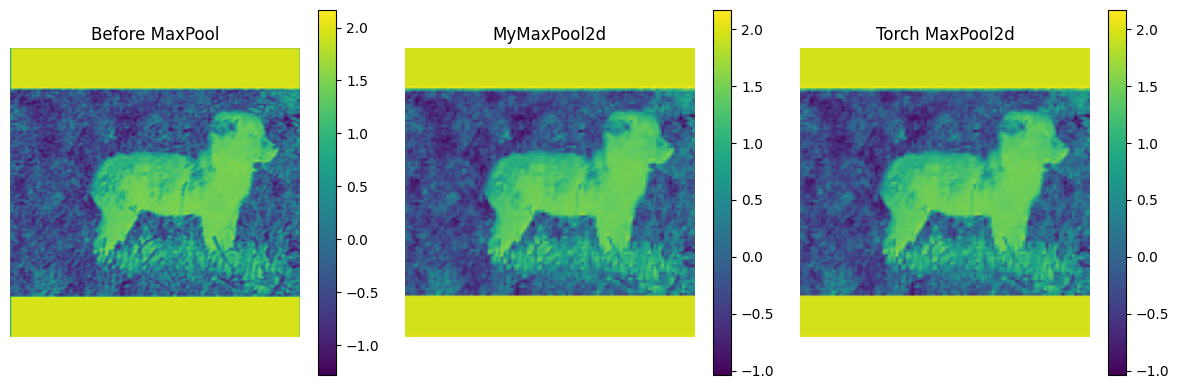

In [8]:
x = out_my[:1]
my_pool = MyMaxPool2d(kernel_size=2, stride=2)
torch_pool = nn.MaxPool2d(kernel_size=2, stride=2)

with torch.no_grad():
    out_my_pool = my_pool(x)
    out_torch_pool = torch_pool(x)

print("Output shape:", out_my_pool.shape)
print("Max absolute diff:",
      (out_my_pool - out_torch_pool).abs().max().item())

plt.figure(figsize=(12, 4))

# Before pooling
plt.subplot(1, 3, 1)
show_feature_map(x[0, 0], "Before MaxPool")

# MyMaxPool2d
plt.subplot(1, 3, 2)
show_feature_map(out_my_pool[0, 0], "MyMaxPool2d")

# Torch MaxPool2d
plt.subplot(1, 3, 3)
show_feature_map(out_torch_pool[0, 0], "Torch MaxPool2d")

plt.tight_layout()
plt.show()


## Model

In [9]:
import torch.nn as nn

class CatsDogsCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 1. Feature Extractor (Backbone)
        # Spatial dimension calculation: O = floor((I + 2P - K) / S) + 1
        self.features = nn.Sequential(
            # Block 1: 224x224 -> 112x112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 112x112 -> 56x56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 56x56 -> 28x28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 28x28 -> 14x14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5: 14x14 -> 7x7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 2. Classifier Head
        # After 5 MaxPool layers, 224 / 2^7 = 7
        # The last feature block outputs 512 channels.
        # So, the flattened size is 512 * 7 * 7
        self.classifier = nn.Sequential(
            nn.Flatten(), # Equivalent to your MyFlatten class
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Regularization (Hinton et al., 2012)
            nn.Linear(512, 2) # Binary classification: 0=Cat, 1=Dog
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CatsDogsCNN()
print(model)


CatsDogsCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## Training loop

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CatsDogsCNN().to(device)

learning_rate = 1e-3
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# This training loop is OK, but I want to add a Process bar to see more infor
# def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
#     for epoch in range(epochs):
#         # Training
#         model.train()
#         train_loss = 0.0
#         correct_train = 0
#         total_train = 0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total_train += labels.size(0)
#             correct_train += predicted.eq(labels).sum().item()

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct_val = 0
#         total_val = 0

#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item()
#                 _, predicted = outputs.max(1)
#                 total_val += labels.size(0)
#                 correct_val += predicted.eq(labels).sum().item()

#         # Display statistics
#         print(f"Epoch {epoch+1}/{epochs}")
#         print(f"Train Acc: {100.*correct_train/total_train:.2f}% | Loss: {train_loss/len(train_loader):.4f}")
#         print(f"Val Acc: {100.*correct_val/total_val:.2f}% | Loss: {val_loss/len(val_loader):.4f}")
#         print("-" * 30)

# train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)

cuda


### Add process bar for training loop

In [11]:
from tqdm import tqdm

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_bar = tqdm(
            train_loader,
            desc="Training",
            leave=False,
            unit="batch"
        )

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

            # Update tqdm postfix
            train_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{100.*correct_train/total_train:.2f}%"
            })

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_bar = tqdm(
            val_loader,
            desc="Validation",
            leave=False
        )

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                val_bar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{100.*correct_val/total_val:.2f}%"
                })

        # SUMMARY
        print(f"Train Acc: {100.*correct_train/total_train:.2f}% | "
              f"Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val   Acc: {100.*correct_val/total_val:.2f}% | "
              f"Loss: {val_loss/len(val_loader):.4f}")
        print("-" * 30)

    torch.save(model.state_dict(), "cats_dogs_model.pth")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)


Epoch 1/10


Train Acc: 56.08% | Loss: 1.9607
Val   Acc: 59.74% | Loss: 0.6539
------------------------------

Epoch 2/10


Train Acc: 62.84% | Loss: 0.6353
Val   Acc: 64.08% | Loss: 0.6185
------------------------------

Epoch 3/10


Train Acc: 68.05% | Loss: 0.5935
Val   Acc: 66.68% | Loss: 0.5915
------------------------------

Epoch 4/10


Train Acc: 72.39% | Loss: 0.5413
Val   Acc: 68.84% | Loss: 0.5935
------------------------------

Epoch 5/10


Train Acc: 76.87% | Loss: 0.4882
Val   Acc: 75.46% | Loss: 0.4864
------------------------------

Epoch 6/10


Train Acc: 79.90% | Loss: 0.4377
Val   Acc: 79.00% | Loss: 0.4387
------------------------------

Epoch 7/10


Train Acc: 82.57% | Loss: 0.3964
Val   Acc: 81.61% | Loss: 0.4042
------------------------------

Epoch 8/10


Train Acc: 83.85% | Loss: 0.3628
Val   Acc: 84.79% | Loss: 0.3436
------------------------------

Epoch 9/10


Train Acc: 86.20% | Loss: 0.3264
Val   Acc: 81.06% | Loss: 0.4569
------------------------------

Epoch 10/10


Train Acc: 87.65% | Loss: 0.2908
Val   Acc: 84.73% | Loss: 0.3641
------------------------------


In [12]:
 # release memory
import gc;del model;del criterion;del optimizer;del images, labels;gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

from google.colab import runtime
print("Shutting down now.")
runtime.unassign()

Shutting down now.
